https://www.kaggle.com/rakeshrau/social-network-ads

In [1]:
import pandas as pd
import numpy as np
from qSUN.qCircuit import *
from qSUN.qGATES import *
from qSUN.qMEAS import *
import time
import math

In [2]:
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [4]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
ampl_0 = np.sqrt(X_train[0][0])
ampl_1 = np.sqrt(1-X_train[0][0])
print(X_train[0])

[0.95238095 0.95555556]


In [8]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def initial_state(sample):
    circuit = Qubit(2)
    ampl_0_0 = np.sqrt(sample[0])
    ampl_0_1 = np.sqrt(1-sample[0])
    ampl_1_0 = np.sqrt(sample[1])
    ampl_1_1 = np.sqrt(1-sample[1])
    circuit.amplitude = np.array([ampl_0_0*ampl_1_0, ampl_0_0*ampl_1_1, ampl_0_1*ampl_1_0, ampl_1_1*ampl_1_1])
    return circuit

def layer(circuit, params):
    circuit_layer = circuit
    RX(circuit_layer, 0, params[0][0])
    RY(circuit_layer, 0, params[0][1])
    RX(circuit_layer, 1, params[1][0])
    RY(circuit_layer, 1, params[1][1])
    CNOT(circuit_layer, 0, 1)
    CNOT(circuit_layer, 1, 0)
    return circuit_layer

def qnn(sample, params, n_layer):
    circuit_qnn = initial_state(sample)
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    exp_0 = prob_0[1]
    exp_1 = prob_1[1]
    if sigmoid(exp_0) > sigmoid(exp_1):
        return 1
    else:
        return 0
    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(params, n_layer, features, labels):
    preds = [predict(qnn(x, params, n_layer)) for x in features]
    return square_loss(labels, preds)

def grad(X_true, y_true, params, n_layer, shift, eta):
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params_1 = params.copy()
                params_2 = params.copy()
                params_1[i][j][k] += shift
                params_2[i][j][k] -= shift
                diff[i][j][k] = (cost(params_1, n_layer, X_true, y_true)
                                 -cost(params_2, n_layer, X_true, y_true))/(2*np.sin(shift))
                    
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params[i][j][k] = params[i][j][k] - eta*diff[i][j][k]
                
    return params

In [9]:
circuit = initial_state(X_train[0])
measure_one(circuit, 0)

array([0.95238095, 0.04761905])

In [19]:
n_layer = 3
params = np.random.normal(size=(n_layer, 2, 2,))
diff = np.zeros((n_layer, 2, 2,))

In [20]:
cost(params, n_layer, X_train, y_train)

0.378125

In [21]:
start = time.time()
for i in range(100):
    params = grad(X_train, y_train, params, n_layer, np.pi/20, eta=0.01)
end = time.time() 

In [22]:
cost(params, n_layer, X_train, y_train)

0.234375

In [23]:
cost(params, n_layer, X_test, y_test)

0.2

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

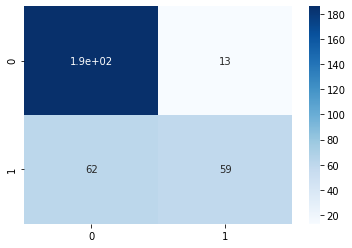

In [27]:
label = y_train
pred = [predict(qnn(x, params, n_layer)) for x in X_train]
con = confusion_matrix(label,pred)
sn.heatmap(con, annot=True, cmap="Blues")

In [35]:
print(sum(y_train==1), sum(y_train==0))

121 199


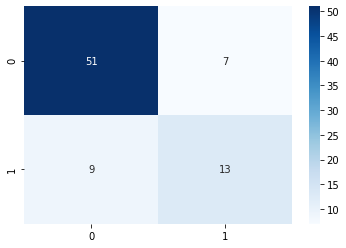

In [28]:
label = y_test
pred = [predict(qnn(x, params, n_layer)) for x in X_test]
con = confusion_matrix(label,pred)
sn.heatmap(con, annot=True, cmap="Blues")

In [34]:
print(sum(y_test==1), sum(y_test==0))

22 58


In [36]:
from sklearn.neural_network import MLPClassifier

In [42]:
clf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic').fit(X_train, y_train)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


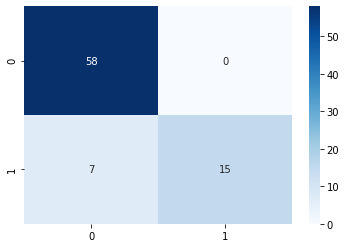

In [43]:
label = y_test
pred = clf.predict(X_test)
con = confusion_matrix(label,pred)
sn.heatmap(con, annot=True, cmap="Blues")

In [45]:
sum((label==1) & (pred==0))

7

# QNN 

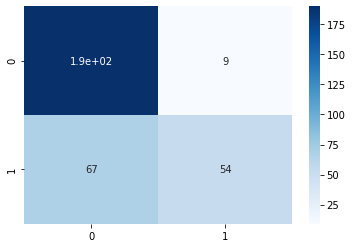

In [47]:
# import libraries
from qSUN.qCircuit import *
from qSUN.qGATES import *
from qSUN.qMEAS import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sn

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# encoding the features
def initial_state(sample):
    circuit = Qubit(2)
    ampl_0_0 = np.sqrt(sample[0])
    ampl_0_1 = np.sqrt(1-sample[0])
    ampl_1_0 = np.sqrt(sample[1])
    ampl_1_1 = np.sqrt(1-sample[1])
    circuit.amplitude = np.array([ampl_0_0*ampl_1_0, ampl_0_0*ampl_1_1, ampl_0_1*ampl_1_0, ampl_1_1*ampl_1_1])
    return circuit

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    RX(circuit_layer, 0, params[0][0])
    RY(circuit_layer, 0, params[0][1])
    RX(circuit_layer, 1, params[1][0])
    RY(circuit_layer, 1, params[1][1])
    CNOT(circuit_layer, 0, 1)
    CNOT(circuit_layer, 1, 0)
    return circuit_layer

# the whole QNN
def qnn(sample, params):
    n_layer = len(params)
    circuit_qnn = initial_state(sample)
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    exp_0 = prob_0[1]
    exp_1 = prob_1[1]
    if sigmoid(exp_0) > sigmoid(exp_1):
        return 1
    else:
        return 0

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta):
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params_1 = params.copy()
                params_2 = params.copy()
                params_1[i][j][k] += shift
                params_2[i][j][k] -= shift
                diff[i][j][k] = (cost(params_1, X_true, y_true)
                                 -cost(params_2, X_true, y_true))/(2*np.sin(shift))
                    
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                params[i][j][k] = params[i][j][k] - eta*diff[i][j][k]
                
    return params

# create parameters  
n_layer = 3
params = np.random.normal(size=(n_layer, 2, 2,))
diff = np.zeros((n_layer, 2, 2,))

#source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# training model
for i in range(100):
    params = grad(X_train, y_train, params, np.pi/20, eta=0.01)

# confusion matrix
label = y_train
pred = [predict(qnn(x, params)) for x in X_train]
con = confusion_matrix(label,pred)
sn.heatmap(con, annot=True, cmap="Blues")

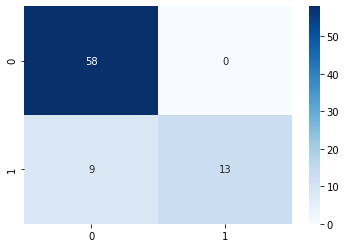

In [50]:
label = y_test
pred = [predict(qnn(x, params)) for x in X_test]
con = confusion_matrix(label,pred)
sn.heatmap(con, annot=True, cmap="Blues")